<a href="https://colab.research.google.com/github/wdwzyyg/Atom-Finder/blob/main/Xin's_AtomSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.test.gpu_device_name()

TensorFlow 1.x selected.


'/device:GPU:0'

In [ ]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/wdwzyyg/AtomSegNet.git

Cloning into 'AtomSegNet'...
remote: Enumerating objects: 901, done.
remote: Total 901 (delta 0), reused 0 (delta 0), pack-reused 901
Receiving objects: 100% (901/901), 300.15 MiB | 28.26 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Checking out files: 100% (640/640), done.


###Modules

In [ ]:
import os
import sys
from os.path import exists
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from PIL import Image, ImageDraw
from skimage.filters import sobel
from skimage.measure import regionprops
from skimage.morphology import opening, watershed, disk, erosion

import h5py
import glob

%cd /content/AtomSegNet
#from UI_files.Atom_Seg_Ui import Ui_MainWindow
from utils.utils import GetIndexRangeOfBlk, load_model, PIL2Pixmap, map01


/content/AtomSegNet


### Functions in one class

In [ ]:
class Code_Main():
  def __init__(self, parent=None):
    super(Code_Main, self).__init__()

    self.ori_image = None
    self.ori_content = None  # original image, PIL format
    self.output_image = None  # output image of model, PIL format
    self.ori_markers = None  # for saving usage, it's a rgb image of original, and with detection result on it
    self.out_markers = None  # for saving usage, it's a rgb image of result after denoising, and with detection result on it
    self.model_output_content = None  # 2d array of model output
    self.result = None
    self.denoised_image = None
    self.props = None

    self.__curdir = os.getcwd()  # current directory  
    self.set_iter = 1            # set Iteration 1-5
    self.se_num = 0              # se_num for Denoise() level: 0-20
    #self.savepath = None  # set save path

    self.imarray_original = None
    self.__model_dir = "model_weights"
    self.__models = {
        'circularMask': os.path.join(self.__model_dir, 'circularMask.pth'),
        'circularMask_mse_beta': os.path.join(self.__model_dir, 'circularMask_mse_beta.pth'),
        'circularMask_chi10_beta': os.path.join(self.__model_dir, 'circularMask_chi10_beta.pth'),
        'cicularMask_chi100_beta': os.path.join(self.__model_dir, 'circularMask_chi100_beta.pth'),
        'guassianMask': os.path.join(self.__model_dir, 'guassianMask.pth'),
        'gaussianMask+': os.path.join(self.__model_dir, 'gaussianMask+.pth'),
        'denoise': os.path.join(self.__model_dir, 'denoise.pth'),
        'denoise&bgremoval': os.path.join(self.__model_dir, 'denoise&bgremoval.pth'),
        'denoise&bgremoval&superres': os.path.join(self.__model_dir, 'denoise&bgremoval&superres.pth'),
        'denoise&airysuperrez_beta': os.path.join(self.__model_dir, 'denoise&airysuperrez_beta.pth')
        }

    """from torch.cuda import is_available
    self.use_cuda.setChecked(is_available())
    self.use_cuda.setDisabled(not is_available())"""

    self.imagePath_content = None

  def BrowseFolder(self,path):
        
        self.imagePath_content = self.imagePath_content if not path else path

        if self.imagePath_content:
            file_name = os.path.basename(self.imagePath_content)
            _, suffix = os.path.splitext(file_name)
            # file_name = self.imagePath_content.split('/')[-1]
            # suffix = '.' + file_name.split('.')[-1]
            if suffix == '.ser':
                from file_readers.ser_lib.serReader import serReader
                ser_data = serReader(self.imagePath_content)
                ser_array = np.array(ser_data['imageData'], dtype='float64')
                self.imarray_original = ser_array
                ser_array = (map01(ser_array) * 255).astype('uint8')
                self.ori_image = Image.fromarray(ser_array, 'L')
            elif suffix == '.dm3':
                from file_readers import dm3_lib as dm3
                data = dm3.DM3(self.imagePath_content).imagedata
                self.imarray_original = np.array(data)
                data = np.array(data, dtype='float64')
                data = (map01(data) * 255).astype('uint8')
                self.ori_image = Image.fromarray(data, mode='L')
            elif suffix == '.tif':
                im = Image.open(self.imagePath_content).convert('L')
                self.imarray_original = np.array(im, dtype='float64')
                self.ori_image = Image.fromarray((map01(self.imarray_original) * 255).astype('uint8'), mode='L')
            else:
                self.ori_image = Image.open(self.imagePath_content).convert('L')
                self.imarray_original = np.array(self.ori_image)

            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image

  def __load_model(self):
        #if not self.ori_image:
            #raise Exception("No image is selected.")

        # cuda=1 if use cuda
        self.cuda = 0
        # set 'Down sample by 2' 'Up sample by 2' or by 3, 4
        self.change_size = 'Do Nothing' 
        # split = 1 will split image larger than 1024 automatically
        self.split = 0

        model_path = os.path.join(self.__curdir, self.__models[self.model_name])

        if self.change_size == 'Down sample by 2':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width // 2, self.height // 2), Image.BILINEAR)
        elif self.change_size == 'Up sample by 2':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width * 2, self.height * 2), Image.BICUBIC)
        elif self.change_size == 'Down sample by 3':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width // 3, self.height // 3), Image.BILINEAR)
        elif self.change_size == 'Up sample by 3':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width * 3, self.height * 3), Image.BICUBIC)
        elif self.change_size == 'Down sample by 4':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width // 4, self.height // 4),
                                                     Image.BILINEAR)
        elif self.change_size == 'Up sample by 4':
            self.width, self.height = self.ori_image.size
            self.ori_content = self.ori_image.resize((self.width * 4, self.height * 4),
                                                     Image.BICUBIC)
        else:
            self.ori_content = self.ori_image


        self.width, self.height = self.ori_content.size

        if self.split == 1:

            if self.height > 1024 and self.height < 2000:
                blk_row = 2
            else:
                if self.height > 2000:
                    blk_row = 4
                else:
                    blk_row = 1

            if self.width > 1024 and self.width < 2000:
                blk_col = 2
            else:
                if self.width > 2000:
                    blk_col = 4
                else:
                    blk_col = 1
        else:
            blk_col = 1
            blk_row = 1

        self.result = np.zeros((self.height, self.width)) - 100

        for r in range(0, blk_row):
            for c in range(0, blk_col):
                inner_blk, outer_blk = GetIndexRangeOfBlk(self.height, self.width, blk_row, blk_col, r, c,
                                                          over_lap=int(self.width * 0.01))
                temp_image = self.ori_content.crop((outer_blk[0], outer_blk[1], outer_blk[2], outer_blk[3]))
                temp_result = load_model(model_path, temp_image, self.cuda, self.set_iter)
                #                temp_result = map01(temp_result)
                self.result[outer_blk[1]: outer_blk[3], outer_blk[0]: outer_blk[2]] = np.maximum(temp_result,
                                                                                                 self.result[
                                                                                                 outer_blk[1]:outer_blk[
                                                                                                     3], outer_blk[0]:
                                                                                                         outer_blk[2]])
        self.result[self.result < 0] = 0
        self.model_output_content = map01(self.result)
        self.model_output_content = (self.model_output_content * 255 / np.max(self.model_output_content)).astype(
            'uint8')
        self.output_image = Image.fromarray((self.model_output_content), mode='L')
       
        del temp_image
        del temp_result
      
  def LoadModel(self, modelPath):
    #   'circularMask_mse_beta'  
    #   'circularMask_chi10_beta'
    #   'cicularMask_chi100_beta'
    #   'guassianMask'
    #   'gaussianMask+'
    #   'denoise'
    #   'denoise&bgremoval'
    #   'denoise&bgremoval&superres'
    #   'denoise&airysuperrez_beta'
        self.model_name = modelPath
        self.__load_model()
        self.Denoise()

  def Denoise(self):

        self.denoise_method = 'Opening'  # 'Erosion'

        radius = self.se_num
        """changes should be done on the kernel generation"""
        kernel = disk(radius)

        if self.denoise_method == 'Opening':
            self.denoised_image = opening(self.model_output_content, kernel)
        else:
            self.denoised_image = erosion(self.model_output_content, kernel)

        temp_image = Image.fromarray(self.denoised_image, mode='L')

        del temp_image

  def CircleDetect(self):

        self.set_thre = 0  # 1 if set threshold
        self.thre = 100    # default threshold
        #if not self.imagePath_content:
            #raise Exception("No image is selected.")

        elevation_map = sobel(self.denoised_image)

        from scipy import ndimage as ndi
        markers = np.zeros_like(self.denoised_image)
        if self.set_thre and self.thre:
            max_thre = int(self.thre) * 2.55
        else:
            max_thre = 100

        min_thre = 30
        markers[self.denoised_image < min_thre] = 1
        markers[self.denoised_image > max_thre] = 2

        seg_1 = watershed(elevation_map, markers)

        filled_regions = ndi.binary_fill_holes(seg_1 - 1)

        label_objects, nb_labels = ndi.label(filled_regions)

        self.props = regionprops(label_objects)

        self.out_markers = Image.fromarray(np.dstack((self.denoised_image, self.denoised_image, self.denoised_image)),
                                           mode='RGB')

        ori_array = np.array(self.ori_content)
        self.ori_markers = Image.fromarray(np.dstack((ori_array, ori_array, ori_array)), mode='RGB')

        del elevation_map
        del markers, seg_1, filled_regions, label_objects, nb_labels

        draw_out = ImageDraw.Draw(self.out_markers)
        draw_ori = ImageDraw.Draw(self.ori_markers)

        for p in self.props:
            c_y, c_x = p.centroid
            draw_out.ellipse([min([max([c_x - 2, 0]), self.width]), min([max([c_y - 2, 0]), self.height]),
                              min([max([c_x + 2, 0]), self.width]), min([max([c_y + 2, 0]), self.height])],
                             fill='red', outline='red')
            draw_ori.ellipse([min([max([c_x - 2, 0]), self.width]), min([max([c_y - 2, 0]), self.height]),
                              min([max([c_x + 2, 0]), self.width]), min([max([c_y + 2, 0]), self.height])],
                             fill='red', outline='red')
            
  def GetSavePath(self): 
  # return savepath+001033.010001/001033.010001
        file_name = os.path.basename(self.imagePath_content)  #001033.010001.h5
        _, suffix = os.path.splitext(file_name)
        if suffix in ['.ser', '.dm3', '.tif']:
            name_no_suffix = file_name.replace(suffix, '')
            suffix = '.png'
        else:
            name_no_suffix = file_name.replace(suffix, '')   #001033.010001
            suffix = '.png'

        if not self.change_size == 'Do Nothing':
            name_no_suffix = name_no_suffix + '_' + self.change_size.currentText()
        has_content = True

       
        path = self.savepath
        save_path = os.path.join(path, name_no_suffix)

        if has_content:
            if not exists(save_path):
                os.mkdir(save_path)
            temp_path = os.path.join(save_path, name_no_suffix)
        else:
            temp_path = None

        return temp_path, suffix   

  def Save(self, opt):

        _path, suffix = self.GetSavePath()
        # _path = savepath+001033.010001/001033.010001
        if _path is None:
            return

        if not _path:
            return

        if opt == 'Atom positions':
          pos_y = []
          pos_x = []
          for p in self.props:
            c_y, c_x = p.centroid
            pos_y.append(c_y)
            pos_x.append(c_x)
          np.save(_path + '_pos_y.npy', np.asarray(pos_y))
          np.save(_path + '_pos_x.npy', np.asarray(pos_x)) 

        if opt == 'Save ALL':
          new_save_name = _path + '_output_' + self.model_name + '.mat'
          scio.savemat(new_save_name, {'result': self.result})
          new_save_name = _path + '_ori_' + self.model_name + '.mat'
          scio.savemat(new_save_name, {'origin': self.imarray_original})

          new_save_name = _path + suffix
          self.ori_content.save(new_save_name)
          new_save_name = _path + '_output_' + self.model_name + suffix
          self.output_image.save(new_save_name)
          new_save_name = _path + '_origin_' + self.model_name + suffix
          self.ori_markers.save(new_save_name)
          new_save_name = _path + '_four_panel_' + self.model_name + suffix
          im_save = Image.new('RGB', ((self.width + 1) * 2, (self.height + 1) * 2))
          im_save.paste(self.ori_content, (0, 0))
          im_save.paste(self.output_image, (self.width + 2, 0))
          im_save.paste(self.ori_markers, (0, self.height + 2))
          im_save.paste(self.out_markers, (self.width + 2, self.height + 2))
          im_save.save(new_save_name)
          del im_save

          new_save_name = _path + '_pos_' + self.model_name + '.txt'
          file = open(new_save_name, 'w')
          for p in self.props:
            c_y, c_x = p.centroid
            min_row, min_col, max_row, max_col = p.bbox
            c_y_int = int(min(max(round(c_y), 0), self.height))
            c_x_int = int(min(max(round(c_x), 0), self.width))
            locations = [str(i) for i in
                          (c_y, c_x, min_row, min_col, max_row, max_col, self.result[c_y_int, c_x_int])]
            file.write(",".join(locations))
            file.write("\n")
          file.close()           
 
          pos_y = []
          pos_x = []
          for p in self.props:
            c_y, c_x = p.centroid
            pos_y.append(c_y)
            pos_x.append(c_x)
          np.save(_path + '_pos_y.npy', np.asarray(pos_y))
          np.save(_path + '_pos_x.npy', np.asarray(pos_x)) 

  def drawPoint(self, event):
        self.pos = event.pos()
        self.update()

  def release(self):
        self.model_output.clear()
        self.se_num = 0
        self.preprocess.clear()
        self.detect_result.clear()
        self.ori.clear()
        del self.props
        del self.output_image
        del self.ori_markers
        del self.out_markers
        return


### Get scores with own data

In [ ]:
def getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance):
  truepoints = []
  pos_se = 0
  tp = 0
  #A_per_px = 25/256 
  # So about 10 px/Angstrom.Considering the atom radius, peak 0.5 angstrom as coordinate limitation, so 5 px or so

  for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))
        pos_se = pos_se + square_error
        tp = tp + 1

  srmse = math.sqrt(pos_se / tp)
  recall = tp / truthnum
  precision = tp / predictpos_x.size
  print('srmse = ', srmse, 'px, recall = ', tp, '/', truthnum, ' = ', recall, ', precision = ', tp, '/', predictpos_x.size, ' = ', precision)
  scores = (srmse, recall, precision)
  return scores 

In [ ]:
totalmse = 0
totalr = 0
totalp= 0
filenum = 0
datapath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/Xin/'
#A_per_px = 0.1088
#tolerance = 20  # set the max square distance we assume right found = (0.5/pxsize)^2

f= open(datapath+'Scores.txt','w+')
f.write('filename ID-recall ID-precision Pos-accuracy(px)\r\n')
#f.write(('Pixel size is %5.4f A, tolerance is %5.2f \r\n' % (A_per_px, tolerance)))
f.close()

srmse =  1.3345196568566993 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136


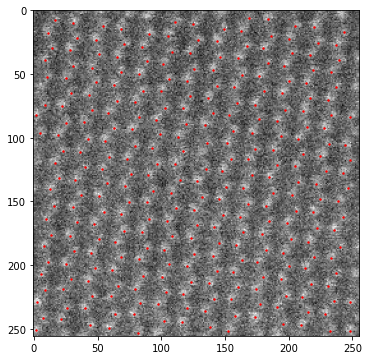

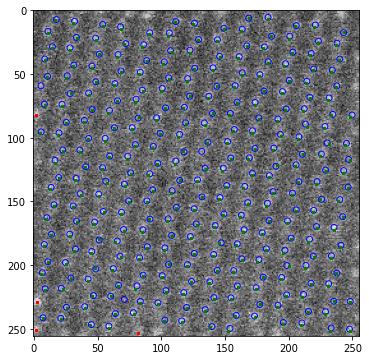

In [ ]:
# Here you load new experimental data (as 2D or 3D numpy array)
path = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-exp/DiffContrast/0d21/'
datapath ='/content/'
#datapath ='/content/drive/MyDrive/AtomfinderProject/Data/WS2-simu/DiffMag/Xin/'
A_per_px = 0.15
tolerance = np.round((0.5/A_per_px)**2, 1)  # set the max square distance we assume right found

mse = 0
r = 0
p = 0

# Use these if to get the only tif in file
for root, dirs, files in os.walk(path):
  for name in files:
    if name[-3:] =='tif':
      filename, _ = os.path.splitext(name) # HAADF_000
im = Image.open(path + filename + '.tif')
expdata = np.asarray(im)

main = Code_Main()
main.__init__()
main.imagePath_content = path+filename+'.npy'

#main.image
Path_content = path
# need to be image file

main.ori_image = im
main.imarray_original = np.asarray(main.ori_image)

main.change_size = 'Do nothing'

main.LoadModel(modelPath =  'gaussianMask+' )
# 'circularMask' 'circularMask_mse_beta' 'circularMask_chi10_beta' 'cicularMask_chi100_beta'  
# 'guassianMask' 'gaussianMask+'  'denoise' 'denoise&bgremoval' 'denoise&bgremoval&superres'
# 'denoise&airysuperrez_beta'
main.CircleDetect()
main.savepath = datapath
main.Save('Atom positions')

predictpos_x = np.load(datapath + filename + '/'+filename+'_pos_x.npy')
predictpos_y = np.load(datapath + filename + '/'+filename+'_pos_y.npy')

#delete predictions at edges
shape = expdata.shape
dellistx = []
for i, coordx in enumerate (predictpos_x):
  dis = abs(coordx-shape[1])/shape[1]
  if dis>0.995 or dis<0.02: # left, right#######################
    dellistx.append(i)
dellisty = []
for i, coordy in enumerate (predictpos_y):
  dis = abs(coordy-shape[0])/shape[0]
  if dis>0.98 or dis<0.01: # up, down##########################
    dellisty.append(i)
dellist = dellistx +dellisty
dellist = np.unique(np.asarray(dellist))
predictpos_x = np.delete(predictpos_x,dellist)
predictpos_y = np.delete(predictpos_y,dellist)

#truthpos_x = np.load('/content/drive/MyDrive/AtomfinderProject/Data/STO-simu/DiffContrast/simulate/direct/Peaks_x.npy')
#truthpos_y = np.load('/content/drive/MyDrive/AtomfinderProject/Data/STO-simu/DiffContrast/simulate/direct/Peaks_y.npy')
truthpos_x = np.load(path+"Peaks_x.npy")
truthpos_y = np.load(path+"Peaks_y.npy")
truthnum = truthpos_x.shape[0]

fig = plt.figure(figsize=(6,6))
plt.imshow(expdata, cmap = 'gray')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')
plt.savefig(datapath+filename+'.png')

srmse, r, p = getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance)

f=open(datapath+'Scores.txt', "a+")
f.write(('%s %5.4f %5.4f %5.4f \r\n' % (filename, r, p, srmse)))
f.write(('Pixel size is %5.4f A, tolerance is %5.2f \r\n' % (A_per_px, tolerance)))
f.close()

#totalmse = totalmse + srmse
#totalr = totalr + r
#totalp= totalp + p
#filenum = filenum+1

del_index = []
truepoints_x = []
truepoints_y = []
for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints_x.append(predictpos_x[i])
        truepoints_y.append(predictpos_y[i])
        del_index.append(i)

#Show false negtive points(precision)
FN_x = np.delete(predictpos_x, del_index)
FN_y = np.delete(predictpos_y, del_index)

fig = plt.figure(figsize=(6,6))
plt.imshow(expdata, cmap = 'gray')
plt.scatter(truthpos_x, truthpos_y,s = 35, facecolors='none', edgecolors='blue')
plt.scatter(FN_x, FN_y,s = 2, c = 'red', marker=',')
plt.scatter(truepoints_x, truepoints_y, s = 2, c = 'g', marker=',')
# Show true negtive points(recall)
plt.savefig(datapath+filename+'color.png')


srmse =  1.3439077019739643 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.2918735375792474 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.2989294032681176 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.3039149442183524 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.3128369770935184 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.320684214725035 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.3345196568566993 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.3439572746421133 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136
srmse =  1.346556

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


srmse =  1.3506129577710992 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


srmse =  1.3533460555322359 px, recall =  288 / 291  =  0.9896907216494846 , precision =  288 / 292  =  0.9863013698630136


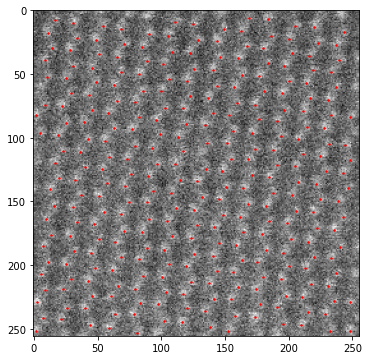

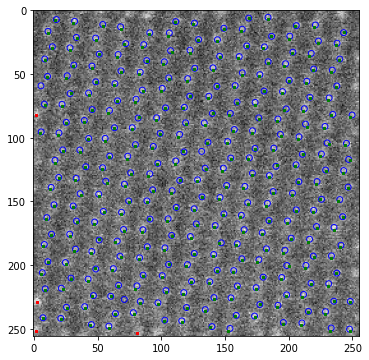

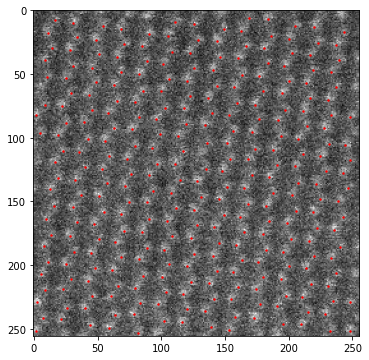

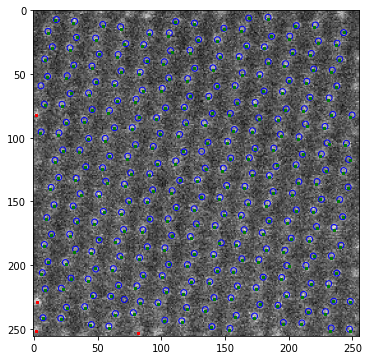

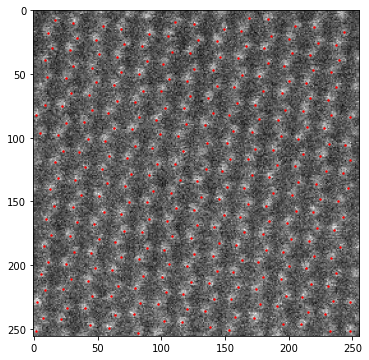

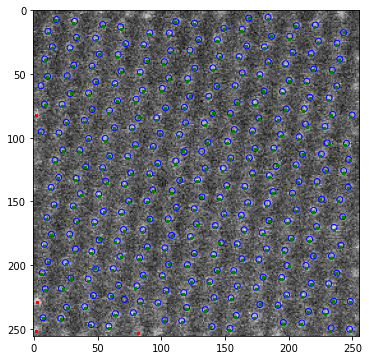

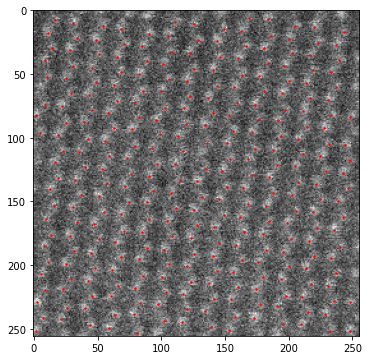

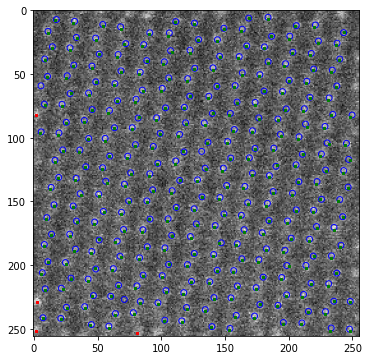

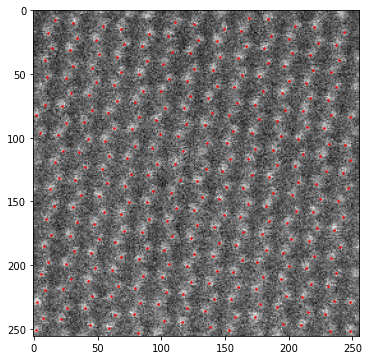

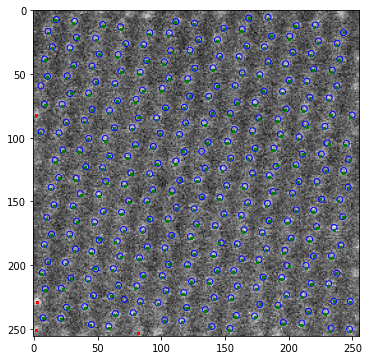

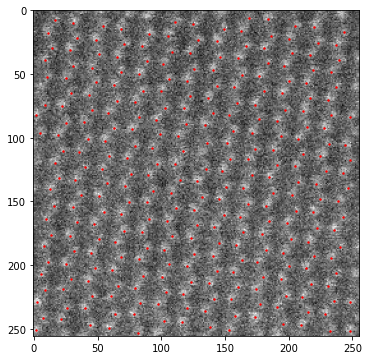

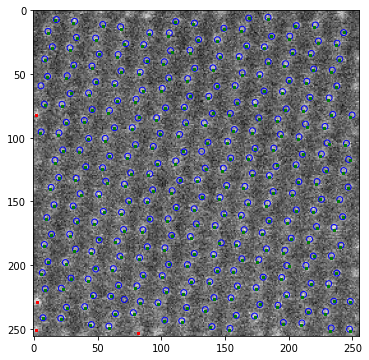

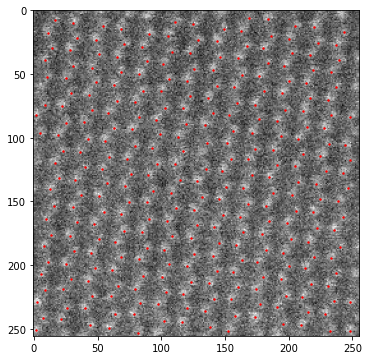

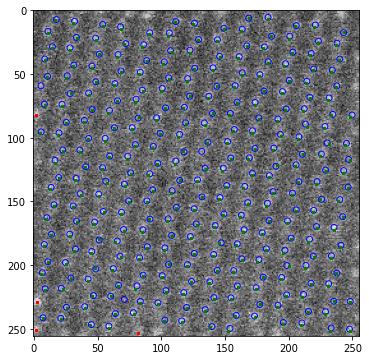

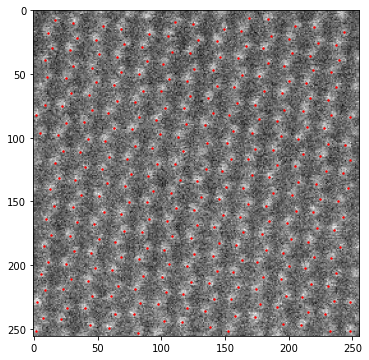

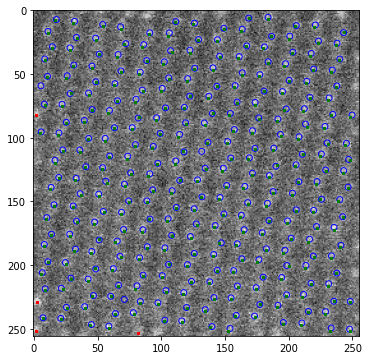

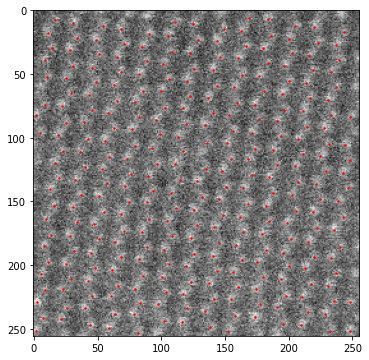

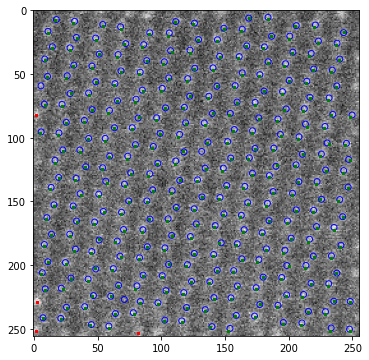

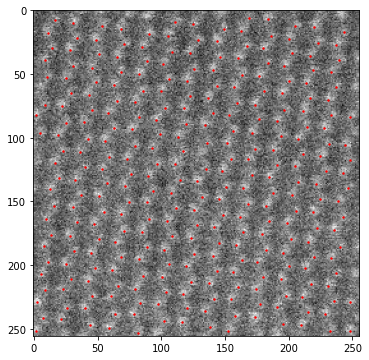

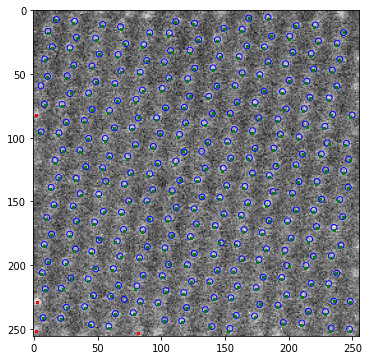

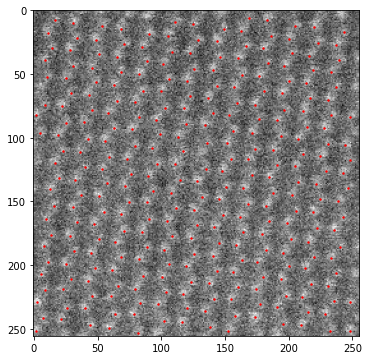

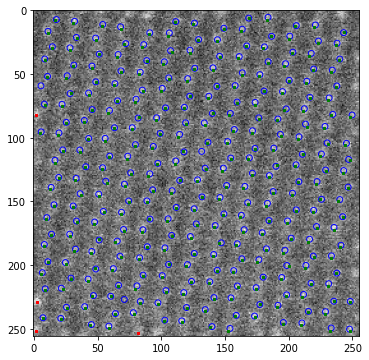

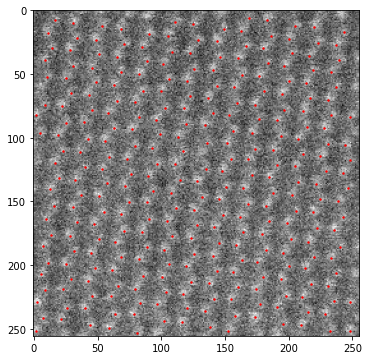

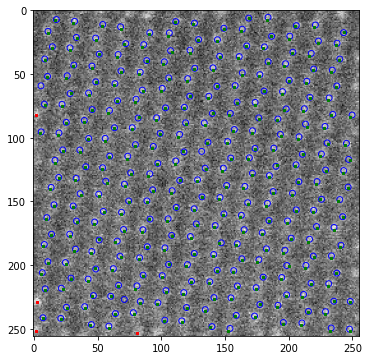

In [ ]:
# code for get scores by loop over folders of image

A_per_px = 0.15
tolerance = np.round((0.5/A_per_px)**2, 1)  # set the max square distance we assume right found

truthpath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-exp/DiffContrast/'
folderlist = os.listdir(truthpath)
datapath = '/content/drive/MyDrive/AtomfinderProject/Data/WS2-exp/DiffContrast/Xin/'
mse = 0
r = 0
p = 0
totalmse = 0
totalr = 0
totalp= 0
filenum = 0
f= open(datapath+'Scores.txt','w+')
f.write('filename ID-recall ID-precision Pos-accuracy(px)\r\n')


for folder in folderlist:
  if folder[0]== 'S' or folder[0]== 'X' or folder[0]== 'N' or folder[0]== 'o':
    continue
  files = os.listdir(truthpath+folder+'/')
  for file in files:
    filename,surfix = os.path.splitext(file)
    if surfix == '.tif':
      im = Image.open(truthpath+folder+'/'+file)
      expdata = np.asarray(im)  
      main = Code_Main()
      main.__init__()
      main.imagePath_content = truthpath+folder+'/'+file


      # need to be image file

      main.ori_image = im
      main.imarray_original = np.asarray(main.ori_image)

      main.change_size = 'Do Nothing'

      main.LoadModel(modelPath =  'gaussianMask+' )
      # 'circularMask' 'circularMask_mse_beta' 'circularMask_chi10_beta' 'cicularMask_chi100_beta'  
      # 'guassianMask' 'gaussianMask+'  'denoise' 'denoise&bgremoval' 'denoise&bgremoval&superres'
      # 'denoise&airysuperrez_beta'
      main.CircleDetect()
      main.savepath = datapath
      main.Save('Atom positions')

      predictpos_x = np.load(datapath + filename + '/'+filename+'_pos_x.npy')
      predictpos_y = np.load(datapath + filename + '/'+filename+'_pos_y.npy')
      
      #delete predictions at edges
      shape = expdata.shape
      dellistx = []
      for i, coordx in enumerate (predictpos_x):
        dis = abs(coordx-shape[1])/shape[1]
        if dis>0.995 or dis<0.02:
          dellistx.append(i)
      dellisty = []
      for i, coordy in enumerate (predictpos_y):
        dis = abs(coordy-shape[0])/shape[0]
        if dis>0.98 or dis<0.01:
          dellisty.append(i)
      dellist = dellistx + dellisty
      dellist = np.unique(np.asarray(dellist))
      if dellist.size != 0:
        predictpos_x = np.delete(predictpos_x,dellist)
        predictpos_y = np.delete(predictpos_y,dellist)
        
      #truthpos_x = np.load('/content/drive/MyDrive/AtomfinderProject/Data/STO-simu/DiffContrast/simulate/direct-old/Peaks_x.npy')
      #truthpos_y = np.load('/content/drive/MyDrive/AtomfinderProject/Data/STO-simu/DiffContrast/simulate/direct-old/Peaks_y.npy')
      truthpos_x = np.load(truthpath+folder+'/Peaks_x.npy')
      truthpos_y = np.load(truthpath+folder+'/Peaks_y.npy')
      #truthpos_x = np.load(truthpath+'Peaks_x.npy')
      #truthpos_y = np.load(truthpath+'Peaks_y.npy')
      truthnum = truthpos_x.shape[0]

      fig = plt.figure(figsize=(6,6))
      plt.imshow(expdata, cmap = 'gray')
      plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')
      plt.savefig(datapath+filename+'.png')
      try: 
        srmse, r, p = getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance)
      except:
        print('Failed'+ folder)
        continue
      f=open(datapath+'Scores.txt', "a+")
      f.write(('%s %5.4f %5.4f %5.4f \r\n' % (filename, r, p, srmse)))
      #f.write(('Pixel size is %5.4f A, tolerance is %5.2f \r\n' % (A_per_px, tolerance)))
      f.close()

      totalmse = totalmse + srmse
      totalr = totalr + r
      totalp= totalp + p
      filenum = filenum+1

      del_index = []
      truepoints_x = []
      truepoints_y = []
      for i in range(predictpos_x.size):
          for j in range(truthpos_x.size):
            square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
            if square_error < tolerance:
              truepoints_x.append(predictpos_x[i])
              truepoints_y.append(predictpos_y[i])
              del_index.append(i)

      #Show false negtive points(precision)
      FN_x = np.delete(predictpos_x, del_index)
      FN_y = np.delete(predictpos_y, del_index)

      fig = plt.figure(figsize=(6,6))
      plt.imshow(expdata, cmap = 'gray')
      plt.scatter(truthpos_x, truthpos_y,s = 35, facecolors='none', edgecolors='blue')
      plt.scatter(FN_x, FN_y,s = 2, c = 'red', marker=',')
      plt.scatter(truepoints_x, truepoints_y, s = 2, c = 'g', marker=',')
      # Show true negtive points(recall)
      plt.savefig(datapath+filename+'color.png')


In [ ]:

truthpath = '/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/'
folderlist = os.listdir(truthpath)
print(folderlist)

### Others backup: 
pip install those\
unpack it (didn't)\
change directory to its top level directory

It seems that  no Qt platform plugin could be initialized because I am running on a remote server. 

In [ ]:
!pip install PyQt5
!pip install PyQt5.sip
!pip install PyQt-builder

In [ ]:
import sys
sys.path.insert(1, "/usr/local/lib/python3.6/dist-packages/PyQt5")
print(sys.path)

['/tensorflow-1.15.2/python3.6', '/usr/local/lib/python3.6/dist-packages/PyQt5', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
!apt-get install libx11-dev libxext-dev libxtst-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libxext-dev is already the newest version (2:1.3.3-1).
libxext-dev set to manually installed.
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
libx11-dev set to manually installed.
The following additional packages will be installed:
  x11proto-record-dev
The following NEW packages will be installed:
  libxtst-dev x11proto-record-dev
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 17.8 kB of archives.
After this operation, 88.1 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11proto-record-dev all 2018.4-4 [2,620 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxtst-dev amd64 2:1.2.3-1 [15.2 kB]
Fetched 17.8 kB in 0s (36.0 kB/s)
Selecting previously unselected package x11proto-record-dev.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../x

In [ ]:
!apt-get install xlibmesa-gl-dev libglu1-mesa-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package xlibmesa-gl-dev


In [ ]:
!export PATH="/usr/local/lib/python3.6/dist-packages/PyQt5/bin:$PATH"


In [ ]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/wdwzyyg/AtomSegNet.git

Cloning into 'AtomSegNet'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 75 (delta 15), reused 22 (delta 8), pack-reused 35
Unpacking objects: 100% (75/75), done.


In [ ]:
#%cd /content/AtomSegNet/
!python /content/AtomSegNet/Code_Atom_Seg_Ui.py

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



In [ ]:
!export QT_DEBUG_PLUGINS=1

Attributes:  ['angstrom_xy', 'chemical_formula', 'hkl_plane', 'icsd_collcode', 'uvw_direction']
Chemical Formula  : 'Ce F3'
ICSD CollCode     : 4
Zone Axis [uvw]   : (0.0, 1.0, 1.0)
Distortion types:  ['peak_map_clean', 'raw', 'stem00-blbk1', 'stem00-clean']


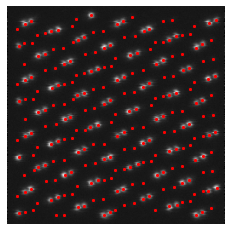

In [ ]:
# Get coodinates from simulation data
import h5py

h5file = h5py.File('/content/AtomSegNet/SimuDataH5/000004.000101.h5', 'r')

print("Attributes: ",list(h5file.attrs.keys()))
print("Chemical Formula  :", h5file.attrs['chemical_formula'].decode("utf-8") )
print("ICSD CollCode     :", h5file.attrs['icsd_collcode'].decode("utf-8") )
print("Zone Axis [uvw]   :", h5file.attrs['uvw_direction'].decode("utf-8") )
print("Distortion types: ",list(h5file['haadf'].keys()))


clean_img = np.array(h5file['haadf']['stem00-clean'])

plt.imshow(clean_img,cmap='gray')
for c in zip(*np.nonzero(np.array(h5file['haadf']['peak_map_clean']))):
    plt.scatter(c[1], c[0], marker='x', c='r', s=5)
    #c[0] is y 
plt.axis('off');plt.show()

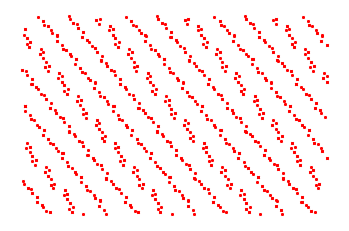

float32


In [ ]:
h5file = h5py.File('/content/AtomSegNet/SimuDataH5/000004.000102.h5', 'r')
coor = h5file['projection']['full_coords']
for c in coor:
    plt.scatter(c[1], c[0], marker='x', c='r', s=5)
    #c[0] is y 
plt.axis('off');plt.show()
print(coor.dtype)

In [ ]:
print('Over', filenum, 'files, mse = ', totalmse/filenum, 'px^2, recall = ',totalr/filenum, ', precision = ', totalp/filenum)
#f=open(datapath+'Scores.txt', "a+")
f.write('Over %d files, recall = %d, precision = %d, mse = %d px' % (filenum, totalr/filenum, totalp/filenum, totalmse/filenum,))
f.close()

Calculate Pos-precision should filter the predictions with UnaryPeaks_x/y by mse

then calculate the precision

In [ ]:
# try to calculate position precision

from scipy.spatial import distance
import statistics

path = '/content/AtomSegNet/ExpData/STOwt/'
folderlist = os.listdir(path)
datapath = '/content/AtomSegNet/Output/'
mse = 0
r = 0
p = 0
totalmse = 0
totalr = 0
totalp= 0

folder = folderlist[0]
file = glob.glob(path+folder+"/*.tif")
main = Code_Main()
main.__init__()
main.imagePath_content = file[0]
   
for root, dirs, files in os.walk(path+folder):
  for name in files:
    if name[-3:] =='tif':
      filename,_ = os.path.splitext(name)

main.ori_image = Image.open(file[0])
main.LoadModel(modelPath = 'denoise&bgremoval&superres')
# 'circularMask' 'circularMask_mse_beta' 'circularMask_chi10_beta' 'cicularMask_chi100_beta'  
# 'guassianMask' 'gaussianMask+'  'denoise' 'denoise&bgremoval' 'denoise&bgremoval&superres'
# 'denoise&airysuperrez_beta'
main.CircleDetect()
main.Save('Atom positions')

predictpos_x = np.load(datapath + filename + '/'+filename+'_pos_x.npy')
predictpos_y = np.load(datapath + filename + '/'+filename+'_pos_y.npy')
truthpos_x = np.load(path+folder+"/Peaks_x.npy")
truthpos_y = np.load(path+folder+"/Peaks_y.npy")
truthnum = truthpos_x.shape[0]
tolerance = 5   # set the max square distance we assume right found

truepoints = []
A_per_px = 25/256 
# Input pixel size for each image

for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))

distances = distance.cdist(truepoints, truepoints, 'euclidean')
print(np.histogram(distances))
plt.imshow(main.ori_markers)
#plt.hist(distances)

distances_avai = distances[(distances < 25) & (distances > 18)]
plt.hist(distances_avai)


print("Standard Deviation of distances is % s " % (statistics.stdev(distances_avai))) 